# Applied Machine Learning CS5785 Homework 1

Group: Ting-Wei Chiang (tc695), Jeremy Shaffer (jms995)


## Programming Exercise 2 - Predicting House Prices

Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
# Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

### (a) Data Preprocessing

In [2]:
# Load dataset

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

#### Data exploration

In [3]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
# train.head()

In [5]:
# test.head()

#### Defining and scaling training target

In [6]:
# train.SalePrice.describe()

Skew for Saleprice = 1.8828757597682129


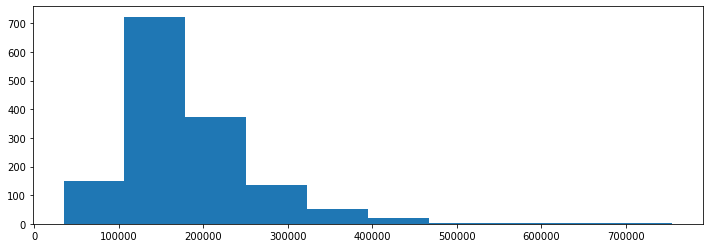

Skew for log(Saleprice) = 0.12133506220520406


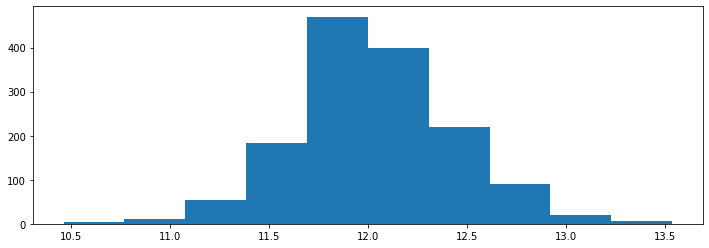

In [7]:
print ("Skew for Saleprice =", train.SalePrice.skew())
plt.hist(train.SalePrice)
plt.show()
print ("Skew for log(Saleprice) =", np.log(train.SalePrice).skew())
plt.hist(np.log(train.SalePrice))    # Looks more like normal distribution after log transformation
plt.show()

In [8]:
# Define training target/label

y_train = np.log(train.SalePrice)

#### Feature Engineering

In [9]:
X = pd.concat([train, test], ignore_index=True)
X = X.drop(columns = ['Id'])

In [10]:
# Numeric features

numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[1:6])
print (corr['SalePrice'].sort_values(ascending=True)[:5])

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
Name: SalePrice, dtype: float64


In [11]:
# Missing Data Imputation: median

X_target = X.SalePrice
X = X.iloc[:, :-1].fillna(X.median())

In [12]:
# Log transform skewed numeric features
numeric_features = X.dtypes[X.dtypes != "object"].index
skewed_features = X[numeric_features].apply(lambda x: x.skew()) #compute skewness
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index
print(skewed_features)
X[skewed_features] = np.log1p(X[skewed_features])

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


In [13]:
# Categorical features

train_null_count = X.isnull().sum()    # can also use df.isna()
train_null_count[train_null_count > 0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
SaleType           1
Exterior2nd        1
KitchenQual        1
Electrical         1
dtype: int64

In [14]:
# One hot encoding

X = pd.get_dummies(X)

In [15]:
X = pd.concat([X, X_target], axis=1)
X_train = X.loc[X['SalePrice'].notna()]
X_test = X.loc[X['SalePrice'].isna()]
# Drop columns
X_train = X_train.drop(columns = ['SalePrice'])
X_test = X_test.drop(columns = ['SalePrice'])

In [16]:
print(X_train.shape)
print(X_test.shape)

(1460, 288)
(1459, 288)


### (b) Linear model: Least squares

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [18]:
X_train_all = X_train
y_train_all = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15)

In [19]:
lr = LinearRegression()
linear_model = lr.fit(X_train, y_train)
print ("R square for Linear Regression =", linear_model.score(X_val, y_val))
print ('RMSE for Linear Regression =', mean_squared_error(y_val, linear_model.predict(X_val), squared=False))

R square for Linear Regression = 0.8635344110091863
RMSE for Linear Regression = 0.14783526514493664


In [20]:
# train model using all training data
linear_model = LinearRegression().fit(X_train_all, y_train_all)

### (c) Regularized Least Squares

#### L1 Regularization: 

In [34]:
alphas = 10**np.arange(-3.8, 0, 0.1)

In [35]:
# choose alpha by min RMSE on validation set

model_list = []
rsquare_list = []
rmse_list = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model = model.fit(X_train, y_train)
    model_list.append(model)
    pred = model.predict(X_val)
    rsquare_list.append(model.score(X_val, y_val))
    rmse_list.append(mean_squared_error(y_val, pred, squared=False))
print("R square for Lasso Regression =", rsquare_list[rmse_list.index(min(rmse_list))])
print("RMSE for Lasso Regression =", min(rmse_list))
print("when alpha =", alphas[rmse_list.index(min(rmse_list))])

lasso_model_2 = model_list[rmse_list.index(min(rmse_list))]

R square for Lasso Regression = 0.8846590255646778
RMSE for Lasso Regression = 0.13591214780524483
when alpha = 0.00015848931924611142


In [36]:
# choose alpha by cross validation on training set

lasso_model = LassoCV(alphas = alphas, cv=5).fit(X_train, y_train)
print ("R square for Lasso Regression =", lasso_model.score(X_val, y_val))
print ("RMSE for Lasso Regression =", mean_squared_error(y_val, lasso_model.predict(X_val), squared=False))
print ("when alpha =", lasso_model.alpha_)

R square for Lasso Regression = 0.8822966758820248
RMSE for Lasso Regression = 0.13729693165806447
when alpha = 0.00031622776601683826


In [37]:
# train model using all training data
lasso_model = Lasso(alpha = lasso_model.alpha_).fit(X_train_all, y_train_all)

Lasso picked 130 variables and eliminated the other 158 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

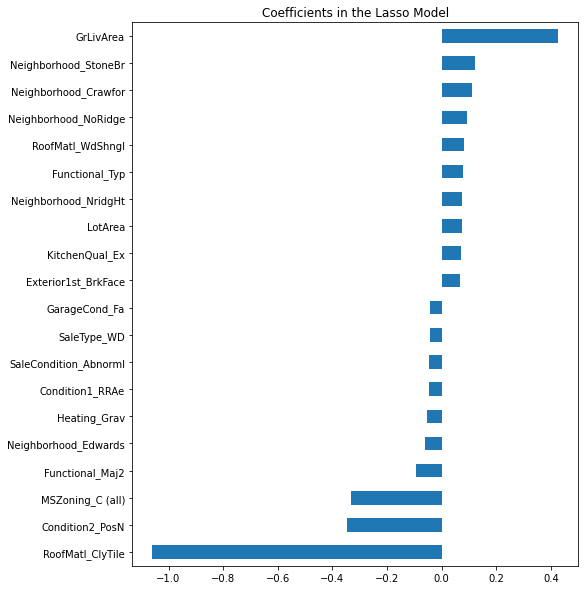

In [25]:
coef = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

#### L2 Regularization:

In [26]:
alphas = 10**np.arange(-2, 2, 0.1)

In [27]:
# choose alpha by min RMSE on validation set

model_list = []
rsquare_list = []
rmse_list = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model = model.fit(X_train, y_train)
    model_list.append(model)
    pred = model.predict(X_val)
    rsquare_list.append(model.score(X_val, y_val))
    rmse_list.append(mean_squared_error(y_val, pred, squared=False))
print("R square for Ridge Regression =", rsquare_list[rmse_list.index(min(rmse_list))])
print("RMSE for Ridge Regression =", min(rmse_list))
print("when alpha =", alphas[rmse_list.index(min(rmse_list))])

ridge_model_2 = model_list[rmse_list.index(min(rmse_list))]

R square for Ridge Regression = 0.8849264523043345
RMSE for Ridge Regression = 0.1357544950922601
when alpha = 0.3162277660168389


In [28]:
# choose alpha by cross validation on training set

ridge_model = RidgeCV(alphas = alphas, cv=5).fit(X_train, y_train)
print ("R square for Ridge Regression =", ridge_model.score(X_val, y_val))
print ("RMSE for Ridge Regression =", mean_squared_error(y_val, ridge_model.predict(X_val), squared=False))
print ("when alpha =", ridge_model.alpha_)

R square for Ridge Regression = 0.8731607267390984
RMSE for Ridge Regression = 0.14252575165691989
when alpha = 15.84893192461124


In [29]:
# train model using all training data
ridge_model = Lasso(alpha = ridge_model.alpha_).fit(X_train_all, y_train_all)

### Submission to Kaggle

In [30]:
pred_linear = np.exp(linear_model.predict(X_test))
pred_lasso = np.exp(lasso_model.predict(X_test))
pred_ridge = np.exp(ridge_model.predict(X_test))

In [31]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_linear
res.to_csv('res_linear_all.csv', index=False)

In [32]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_lasso
res.to_csv('res_lasso_all.csv', index=False)

In [33]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_ridge
res.to_csv('res_ridge_all.csv', index=False)